Describe:
                  ID   Diagnosis  radius_mean  texture_mean  perimeter_mean  \
count  5.690000e+02  569.000000   569.000000    569.000000      569.000000   
mean   3.037183e+07    0.372583    14.127292     19.289649       91.969033   
std    1.250206e+08    0.483918     3.524049      4.301036       24.298981   
min    8.670000e+03    0.000000     6.981000      9.710000       43.790000   
25%    8.692180e+05    0.000000    11.700000     16.170000       75.170000   
50%    9.060240e+05    0.000000    13.370000     18.840000       86.240000   
75%    8.813129e+06    1.000000    15.780000     21.800000      104.100000   
max    9.113205e+08    1.000000    28.110000     39.280000      188.500000   

         area_mean  smoothness_mean  compactness_mean  concavity_mean  \
count   569.000000       569.000000        569.000000      569.000000   
mean    654.889104         0.096360          0.104341        0.088799   
std     351.914129         0.014064          0.052813        0.0797

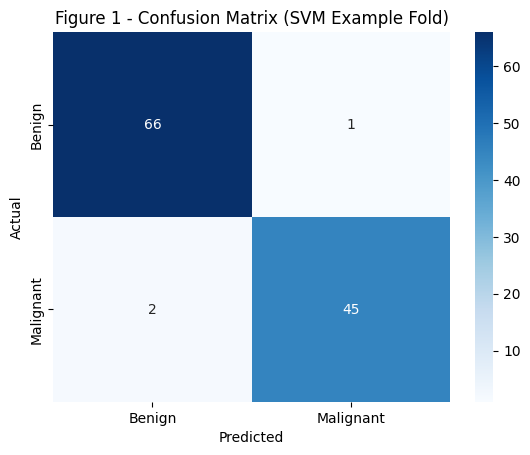

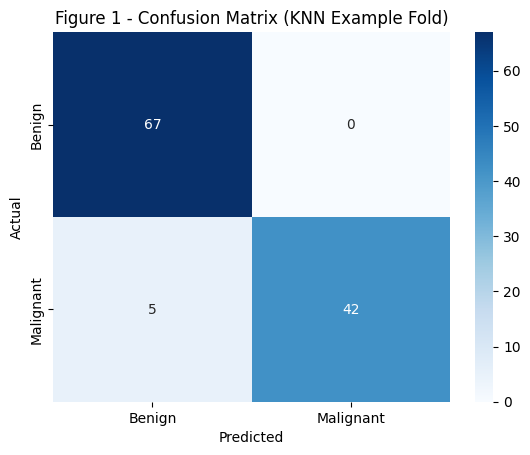

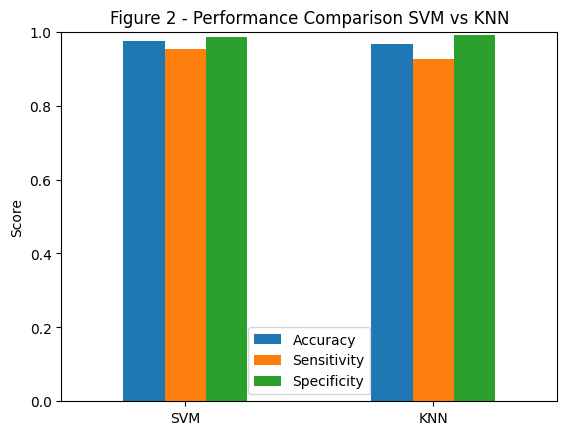

In [3]:
#TASK1

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, matthews_corrcoef, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

columns = ['ID', 'Diagnosis'] + [f'{f}_{t}' for t in ['mean', 'se', 'worst'] for f in ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave points', 'symmetry', 'fractal dimension']]
df = pd.read_csv('wdbc.data', header=None, names=columns)
df['Diagnosis'] = df['Diagnosis'].map({'M':1, 'B':0})  # M=1 (malignant), B=0 (benign)

# EDA
print('Describe:\n', df.describe())
print('Balance:\n', df['Diagnosis'].value_counts(normalize=True))
print('Nulls:', df.isnull().sum().sum())
print('Shape:', df.shape)

# Preprocessing
X = df.drop(['ID', 'Diagnosis'], axis=1)
y = df['Diagnosis']
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Models
models = {
    'SVM': SVC(kernel='rbf', probability=True, random_state=0),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# 10-fold CV
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
results = {}
for name, model in models.items():
    acc, sens, spec, fdr, for_, mcc = [], [], [], [], [], []
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        acc.append(accuracy_score(y_test, y_pred))
        sens.append(recall_score(y_test, y_pred))
        spec.append(tn / (tn + fp) if tn + fp > 0 else 0)
        fdr.append(fp / (fp + tp) if fp + tp > 0 else 0)
        for_.append(fn / (fn + tn) if fn + tn > 0 else 0)
        mcc.append(matthews_corrcoef(y_test, y_pred))
    results[name] = {
        'Accuracy': np.mean(acc), 'Sensitivity': np.mean(sens), 'Specificity': np.mean(spec),
        'FDR': np.mean(fdr), 'FOR': np.mean(for_), 'MCC': np.mean(mcc)
    }

# Table 1
print('Table 1 - Evaluation Metrics (10-fold CV Average):')
print(pd.DataFrame(results).T)

# Figure 1: Confusion Matrix
model = models['SVM']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Figure 1 - Confusion Matrix (SVM Example Fold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# For KNN confusion
model = models['KNN']
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Figure 1 - Confusion Matrix (KNN Example Fold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Figure 2: Bar Comparison (acc, sens, spec for SVM vs KNN)
metrics = pd.DataFrame(results).T[['Accuracy', 'Sensitivity', 'Specificity']]
metrics.plot(kind='bar', rot=0)
plt.title('Figure 2 - Performance Comparison SVM vs KNN')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

In [7]:
#TASK 2

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

columns = ['ID', 'Diagnosis'] + [f'{f}_{t}' for t in ['mean', 'se', 'worst'] for f in ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave points', 'symmetry', 'fractal dimension']]
df = pd.read_csv('wdbc.data', header=None, names=columns)
df['Diagnosis'] = df['Diagnosis'].map({'M':1, 'B':0})

print('Describe:\n', df.describe())
print('Correlations with Diagnosis:\n', df.corr()['Diagnosis'].sort_values(ascending=False))

X = df.drop(['ID', 'Diagnosis'], axis=1)
y = df['Diagnosis']

selector = SelectKBest(f_classif, k=5)
X_selected = selector.fit_transform(X, y)
selected_feats = X.columns[selector.get_support()].tolist()
print('Selected Features (approx paper):', selected_feats)

divisions = {
    '10-fold CV': StratifiedKFold(n_splits=10, shuffle=True, random_state=0),
    '70/30 Holdout': (0.3),
    '80/20 Holdout': (0.2),
    '50/50 Holdout': (0.5)
}

feat_table = {}
acc_table = {}  # Table 4
for name, split in divisions.items():
    if name == '10-fold CV':
        feats = []
        accs = []
        for train_idx, test_idx in split.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
            sel = SelectKBest(f_classif, k=5)
            sel.fit(X_train, y_train)
            feats.append(X.columns[sel.get_support()].tolist())
            X_train_sel = sel.transform(X_train)
            X_test_sel = sel.transform(X_test)
            scaler = StandardScaler()
            X_train_sel = scaler.fit_transform(X_train_sel)
            X_test_sel = scaler.transform(X_test_sel)
            model = SVC(kernel='linear', random_state=0)
            model.fit(X_train_sel, y_train)
            accs.append(accuracy_score(y_test, model.predict(X_test_sel)))
        feat_table[name] = feats[0]
        acc_table[name] = np.mean(accs)
    else:
        test_size = split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
        sel = SelectKBest(f_classif, k=5)
        sel.fit(X_train, y_train)
        feat_table[name] = X.columns[sel.get_support()].tolist()
        X_train_sel = sel.transform(X_train)
        X_test_sel = sel.transform(X_test)
        scaler = StandardScaler()
        X_train_sel = scaler.fit_transform(X_train_sel)
        X_test_sel = scaler.transform(X_test_sel)
        model = SVC(kernel='linear', random_state=0)
        model.fit(X_train_sel, y_train)
        acc_table[name] = accuracy_score(y_test, model.predict(X_test_sel))

print('Table 3 - Selected Features per Division:\n', pd.DataFrame.from_dict(feat_table, orient='index'))
print('Table 4 - Acc for Divisions:\n', pd.Series(acc_table))

# Tables 6/7:
acc_no_sel = []
acc_with_sel = []
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = SVC(kernel='linear', random_state=0)
    model.fit(X_train_scaled, y_train)
    acc_no_sel.append(accuracy_score(y_test, model.predict(X_test_scaled)))

    sel = SelectKBest(f_classif, k=5)
    X_train_sel = sel.fit_transform(X_train, y_train)
    X_test_sel = sel.transform(X_test)
    X_train_sel_scaled = scaler.fit_transform(X_train_sel)
    X_test_sel_scaled = scaler.transform(X_test_sel)
    model.fit(X_train_sel_scaled, y_train)
    acc_with_sel.append(accuracy_score(y_test, model.predict(X_test_sel_scaled)))

print('Table 6 - Acc without Feat Sel (10-fold Avg):', np.mean(acc_no_sel))
print('Table 7 - Acc with Feat Sel (10-fold Avg):', np.mean(acc_with_sel))

Describe:
                  ID   Diagnosis  radius_mean  texture_mean  perimeter_mean  \
count  5.690000e+02  569.000000   569.000000    569.000000      569.000000   
mean   3.037183e+07    0.372583    14.127292     19.289649       91.969033   
std    1.250206e+08    0.483918     3.524049      4.301036       24.298981   
min    8.670000e+03    0.000000     6.981000      9.710000       43.790000   
25%    8.692180e+05    0.000000    11.700000     16.170000       75.170000   
50%    9.060240e+05    0.000000    13.370000     18.840000       86.240000   
75%    8.813129e+06    1.000000    15.780000     21.800000      104.100000   
max    9.113205e+08    1.000000    28.110000     39.280000      188.500000   

         area_mean  smoothness_mean  compactness_mean  concavity_mean  \
count   569.000000       569.000000        569.000000      569.000000   
mean    654.889104         0.096360          0.104341        0.088799   
std     351.914129         0.014064          0.052813        0.0797

Describe:
                  ID   Diagnosis  radius_mean  texture_mean  perimeter_mean  \
count  5.690000e+02  569.000000   569.000000    569.000000      569.000000   
mean   3.037183e+07    0.372583    14.127292     19.289649       91.969033   
std    1.250206e+08    0.483918     3.524049      4.301036       24.298981   
min    8.670000e+03    0.000000     6.981000      9.710000       43.790000   
25%    8.692180e+05    0.000000    11.700000     16.170000       75.170000   
50%    9.060240e+05    0.000000    13.370000     18.840000       86.240000   
75%    8.813129e+06    1.000000    15.780000     21.800000      104.100000   
max    9.113205e+08    1.000000    28.110000     39.280000      188.500000   

         area_mean  smoothness_mean  compactness_mean  concavity_mean  \
count   569.000000       569.000000        569.000000      569.000000   
mean    654.889104         0.096360          0.104341        0.088799   
std     351.914129         0.014064          0.052813        0.0797

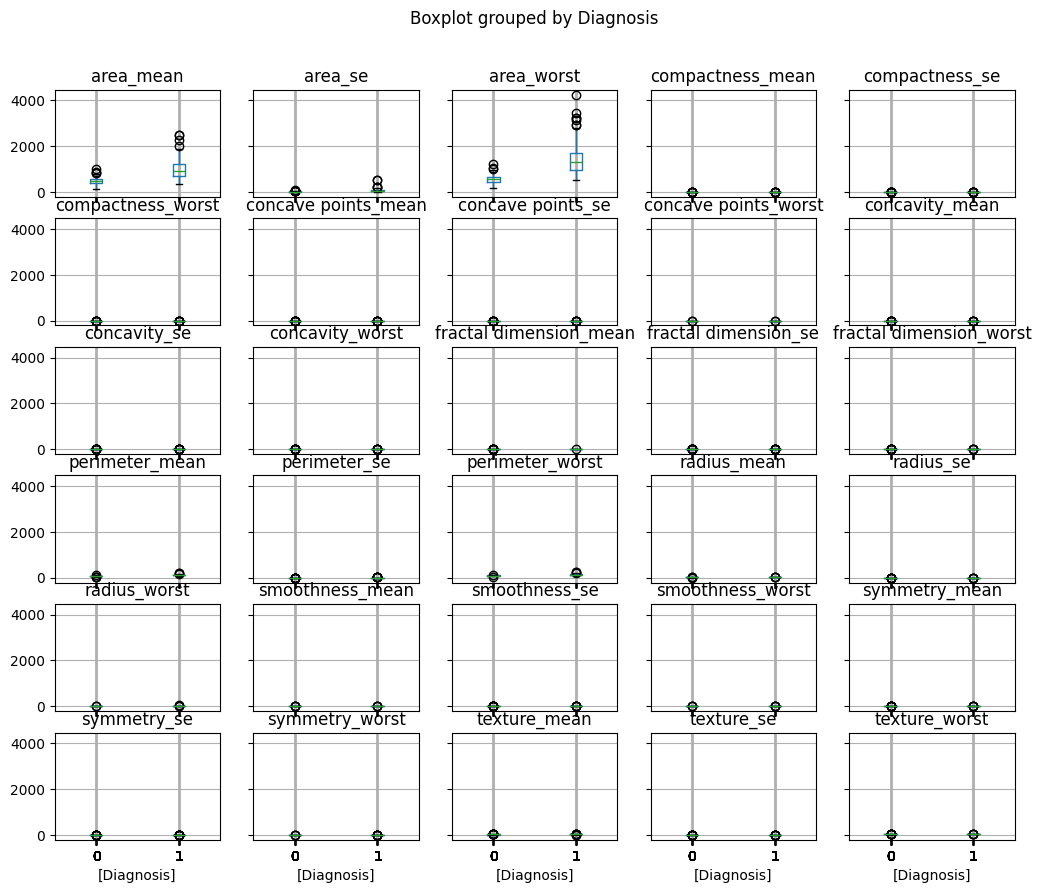

Default Params Acc: {'linear': 0.9649122807017544, 'poly': 0.8947368421052632, 'rbf': 0.9736842105263158, 'sigmoid': 0.9210526315789473}
Tuned poly: Best Params {'C': 1, 'gamma': 0.1}, Acc 0.9649 (vs default 0.8947)
Tuned rbf: Best Params {'C': 10, 'gamma': 0.01}, Acc 0.9825 (vs default 0.9737)
Tuned sigmoid: Best Params {'C': 100, 'gamma': 0.001}, Acc 0.9649 (vs default 0.9211)
Tuned linear: Best Params {'C': 0.1}, Acc 0.9649 (vs default 0.9649)


In [5]:
#TASK 3

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

columns = ['ID', 'Diagnosis'] + [f'{f}_{t}' for t in ['mean', 'se', 'worst'] for f in ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave points', 'symmetry', 'fractal dimension']]
df = pd.read_csv('wdbc.data', header=None, names=columns)
df['Diagnosis'] = df['Diagnosis'].map({'M':1, 'B':0})
print('Describe:\n', df.describe())
print('Balance:\n', df['Diagnosis'].value_counts(normalize=True))
print('Nulls:', df.isnull().sum().sum())
df.drop('ID', axis=1).boxplot(by='Diagnosis', figsize=(12,10))
plt.show()


df = df.drop_duplicates()
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results_default = {}
for k in kernels:
    model = SVC(kernel=k, random_state=0)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    results_default[k] = acc

print('Default Params Acc:', results_default)


param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}
for k in ['poly', 'rbf', 'sigmoid']:
    grid = GridSearchCV(SVC(kernel=k, random_state=0), param_grid, cv=5)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    acc = accuracy_score(y_test, best_model.predict(X_test))
    print(f'Tuned {k}: Best Params {grid.best_params_}, Acc {acc:.4f} (vs default {results_default[k]:.4f})')


grid = GridSearchCV(SVC(kernel='linear', random_state=0), {'C': [0.1, 1, 10, 100]}, cv=5)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
acc = accuracy_score(y_test, best_model.predict(X_test))
print(f'Tuned linear: Best Params {grid.best_params_}, Acc {acc:.4f} (vs default {results_default["linear"]:.4f})')